#Script used to analyze and generate networks for the IASC Water Commons Social-Ecological Network Workshop

Here i will use Python, an open source, high level programming language that is simple to write and read. It is similar to R (and one can actually call R within python, and use R routines and libraries)

#Networks Used for Slides 13,15,16


First, python is a "flexible" language, like R we need to tell it what libraries/packages we want to use (so that it does not load them all to stay unused and use up your memory). So below, we "import" only the packages we are going to

In [1]:
#Matplotlib is a package used for doing plots. Here i create a function (with help from stack-overflow) to draw networks
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#Numpy is a package that allows to do linear algebra routines, call random number generators, and perform mathematical operations.
import numpy as np
#NetworkX is the package that allows you to import, export and analyze networks in Python (or the main package used)
import networkx as nx
#Community is an add on package for community detection (see slide 16)
#so first, we need to install community detection
!pip install community
#then we import community
import community

Imported the packages, now, i am going to write a couple of user written functions to draw the networks. Functions were found on stackoverflow (great resources for all things python and not only)


In [47]:
#here i define colors that i want to use
colm = plt.get_cmap('coolwarm') #used for continous mapping of colors to network characterstics 
colmjet = plt.get_cmap('jet',10) #used for discrete mapping of colors to network characteristics

In [26]:

#define a personalized function to draw networks with colors reflecting nodal characteristics (i.e. degree centrality, betweenness, clustering etc)
#This function is used for the figures in slides 13 and 14
#original code modifiedhere: https://aksakalli.github.io/2017/07/17/network-centrality-measures-and-their-visualization.html
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=colm, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()



In [4]:
#define a function to highlight different "communities" in networks. This function is used to position the nodes in Slide 16
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.
    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot
    partition -- dict mapping int node -> int community
        graph partitions
    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions
    """
    pos_communities = _position_communities(g, partition, scale=3.)
    pos_nodes = _position_nodes(g, partition, scale=1.)
    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]
    return pos
def _position_communities(g, partition, **kwargs):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)
    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))
    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)
    # set node positions to position of community
    pos = dict()
    for node, comt in partition.items():
        pos[node] = pos_communities[comt]
    return pos

def _find_between_community_edges(g, partition):
    edges = dict()
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]
        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]
    return edges
def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """
    communities = dict()
    for node, comt in partition.items():
        try:
            communities[comt] += [node]
        except KeyError:
            communities[comt] = [node]
    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)
    return pos

#Generating and Analyzing a network

In [14]:
#First we generate a network, networkX offers multiple network generators, here we generate a scale free network
#Remember, nx stands for networkx, so we are actually asking: 
#Hey Python, get NetworkX and ask NetworkX to generate a network following the extended barabasi albert graph
net = nx.extended_barabasi_albert_graph(50, 3, 0.3, 0.1, seed=None)
#Hey Python, get NetworkX and ask NetworkX to generate a network following watts and strogatz small world graph
net2 = nx.watts_strogatz_graph(50, 8, 0.1)
print('Scale Free Network')
print(len(net.nodes()))
print(len(net.edges()))
print('Small World Network')
print(len(net2.nodes()))
print(len(net2.edges()))


Scale Free Network
50
210
Small World Network
50
200


Once generated, now we can analyze the networks, note that both have 50 nodes... so they are of the same "size" but...they may differ and those differences are important as they affect processes unfolding on the network themselves.

In [19]:
#First lets calcualte some of the usual suspects: Degree centrality, betweenness centarlity and clustering.
#Note that you can also use the average betweenness function within networkx, 
#here i use numpy to calculate the mean of the values returned by the nodal betweenness centrality scores. 

d1 = nx.degree(net)
d2 = dict(d1)
d3 = list(d2.values())
badeg = np.mean(d3)
babet = np.mean(list(nx.betweenness_centrality(net).values()))
baclus = np.mean(list(nx.clustering(net).values()))
basp = nx.average_shortest_path_length(net)

d1 = nx.degree(net2)
d2 = dict(d1)
d3 = list(d2.values())
swdeg = np.mean(d3)
swbet = np.mean(list(nx.betweenness_centrality(net2).values()))
swclus = np.mean(list(nx.clustering(net2).values()))
swsp = nx.average_shortest_path_length(net2)

#Let's print some results
print('Scale Free Network: ' + 'Avg Deg = '+str(badeg)+'; Avg Bet = '+str(babet)+'; Avg Clus = '+str(baclus)+'; Avg Sh Path Length = '+str(basp))

print('Small World Network: ' + 'Avg Deg = '+str(swdeg)+'; Avg Bet = '+str(swbet)+'; Avg Clus = '+str(swclus)+'; Avg Sh Path Length = '+str(swsp))



Scale Free Network: Avg Deg = 8.4; Avg Bet = 0.021394557823129254; Avg Clus = 0.3644847374847375; Avg Sh Path Length = 2.026938775510204
Small World Network: Avg Deg = 8.0; Avg Bet = 0.028469387755102042; Avg Clus = 0.46473015873015866; Avg Sh Path Length = 2.366530612244898


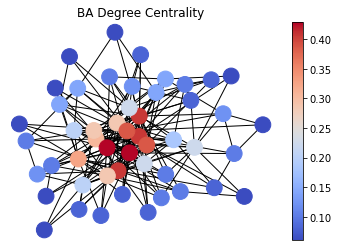

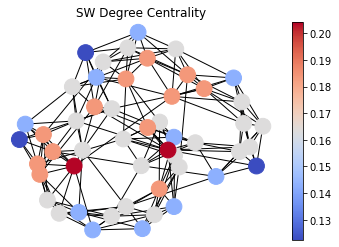

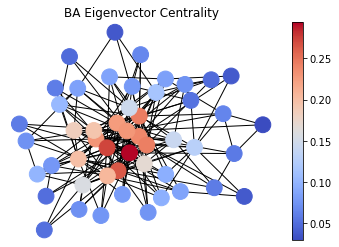

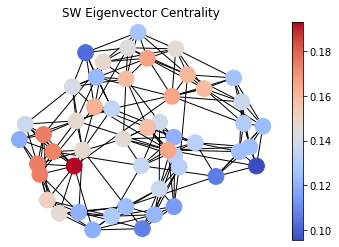

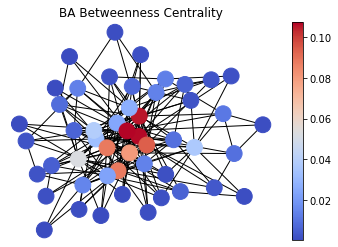

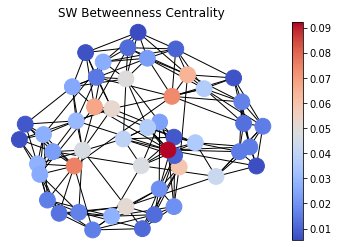

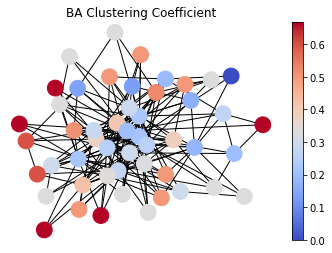

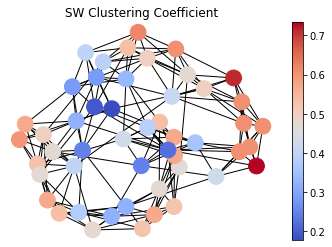

In [35]:
#Let's see a few networks... using the draw function that i defined at the beginning we will be plotting the networks 
#with the same positions, note seed = 550 to make sure that i will have those positions everytime i rerun this
#same script was use to generate the figures in slide 13.
pos = nx.spring_layout(net, seed=550)
pos2 = nx.spring_layout(net2, seed=550)

draw(net, pos, nx.degree_centrality(net), 'BA Degree Centrality')
draw(net2, pos2, nx.degree_centrality(net2), 'SW Degree Centrality')

draw(net, pos, nx.eigenvector_centrality(net), 'BA Eigenvector Centrality')
draw(net2, pos2, nx.eigenvector_centrality(net2), 'SW Eigenvector Centrality')

draw(net, pos, nx.betweenness_centrality(net), 'BA Betweenness Centrality')
draw(net2, pos2, nx.betweenness_centrality(net2), 'SW Betweenness Centrality')

draw(net, pos, nx.clustering(net), 'BA Clustering Coefficient')
draw(net2, pos2, nx.clustering(net2), 'SW Clustering Coefficient')



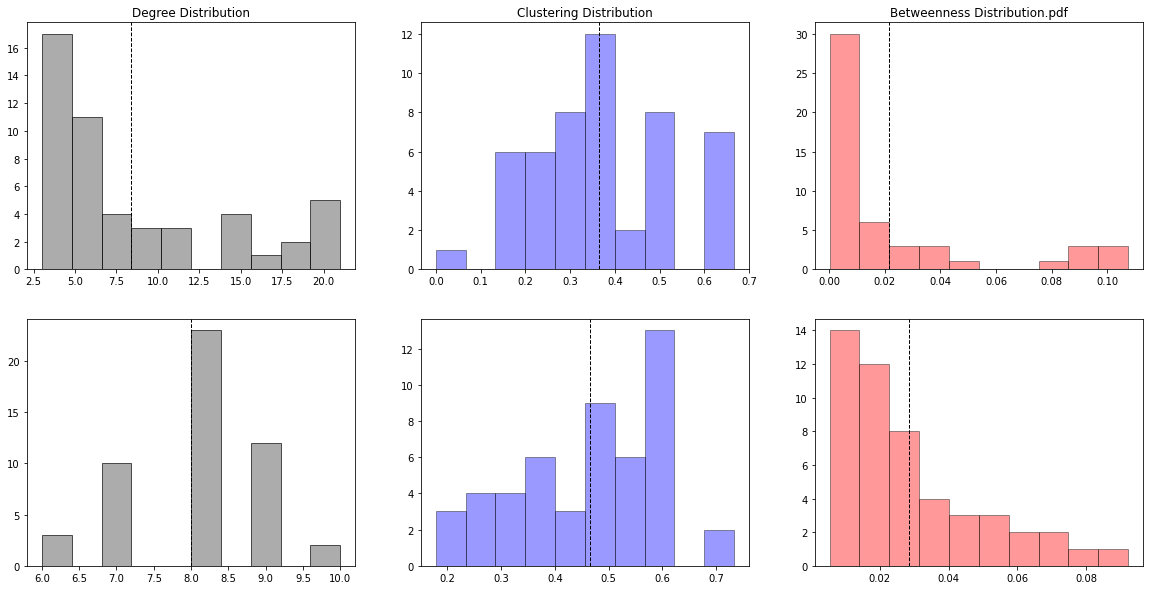

In [36]:
#Now, let's check the distributoin of those values...
#visually here (similar figures as in slide 15)


#Lets have them all in one figure:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2,3, sharey=False, sharex=False, figsize=(20,10)) 

ax1.hist(dict(nx.degree(net)).values(), bins=10, color='grey', edgecolor='k', alpha=0.65)
ax1.axvline(badeg, color='k', linestyle='dashed', linewidth=1)
ax1.set_title('Degree Distribution')
ax2.hist(nx.clustering(net).values(), bins=10, color='b', edgecolor='k', alpha=0.4)
ax2.axvline(baclus, color='k', linestyle='dashed', linewidth=1)
ax2.set_title('Clustering Distribution')
ax3.hist(nx.betweenness_centrality(net).values(), bins=10, color='r', edgecolor='k', alpha=0.4)
ax3.axvline(babet, color='k', linestyle='dashed', linewidth=1)
ax3.set_title('Betweenness Distribution.pdf')
ax4.hist(dict(nx.degree(net2)).values(), bins=10, color='grey', edgecolor='k', alpha=0.65)
ax4.axvline(swdeg, color='k', linestyle='dashed', linewidth=1)
ax5.hist(nx.clustering(net2).values(), bins=10, color='b', edgecolor='k', alpha=0.4)
ax5.axvline(swclus, color='k', linestyle='dashed', linewidth=1)
ax6.hist(nx.betweenness_centrality(net2).values(), bins=10, color='r', edgecolor='k', alpha=0.4)
ax6.axvline(swbet, color='k', linestyle='dashed', linewidth=1)
fig.show()


Modularity Score for BA Network: 0.218015873015873


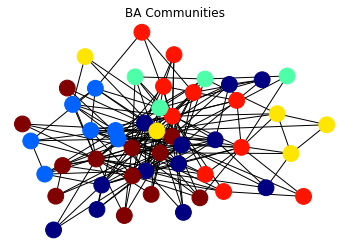

Modularity Score for SW Network: 0.218015873015873


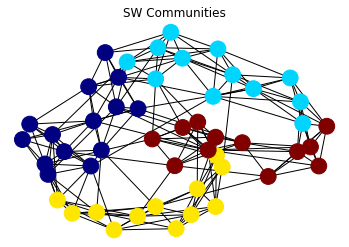

In [69]:
#community and modularity
#change colormap from coolwarm to jet with first 5 colors in draw, for easyness we report again the draw function note the change after cmap.
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=colmjet, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.axis('off')
    plt.show()

com = community.best_partition(net)
mod = community.modularity(com, net)
pos = nx.spring_layout(net, seed = 550)
print('Modularity Score for BA Network: ' + str(mod))
draw(net, pos, com, 'BA Communities')

com2 = community.best_partition(net2)
mod2 = community.modularity(com2, net2)
pos2 = nx.spring_layout(net2, seed = 550)
print('Modularity Score for SW Network: ' + str(mod))
draw(net2, pos2, com2, 'SW Communities')

BA Network and Communities


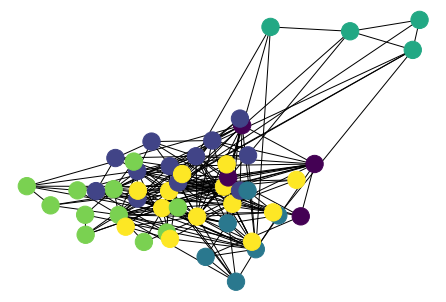

In [65]:
#Now let's draw the networks highlighting the communities
#first the BA network
print('BA Network and Communities')
pos = community_layout(net, com)
nx.draw(net, pos, node_color=list(com.values()))



SW Network and Communities


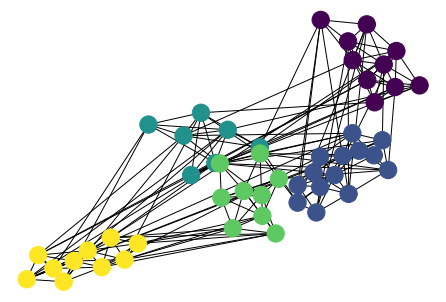

In [68]:
#now the SW network
print('SW Network and Communities')
pos2 = community_layout(net2, com2)
nx.draw(net2, pos2, node_color=list(com2.values()))